I/ Import các thư viện cần thiết

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.7 MB/s eta 0:00:00


In [ ]:
# Essential Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Natural Language Processing (NLP)
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment import SentimentIntensityAnalyzer
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning Models & Pipelines
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier, metrics
from sklearn.pipeline import Pipeline

# Model Evaluation & Metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report
from scipy import stats
from sklearn.model_selection import GridSearchCV

# Feature Engineering & Preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Hyperparameter Tuning
import optuna

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


II/ Load bộ dữ liệu

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/bank_reviews3.csv')

In ra số chiều của dữ liệu

In [ ]:
print(data.shape)

(1000, 10)


In ra 5 dòng đầu của dữ liệu

In [ ]:
data.head()

,author,date,address,bank,rating,review_title_by_user,review,bank_image,rating_title_by_user,useful_count
0,AMRENDRA T,21-Mar-20,New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,https://static.bankbazaar.com/images/common/ba...,Great!,133
1,BISHWA,20-Mar-20,Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,89
2,SANTOSH,20-Mar-20,Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,48
3,MAHADEV,20-Mar-20,Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,https://static.bankbazaar.com/images/common/ba...,Blown Away!,52
4,R,20-Mar-20,Bangalore,review,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",https://static.bankbazaar.com/images/common/ba...,Blown Away!,22


In [ ]:
data.describe()

,rating,useful_count
count,1000.000000,1000.000000
mean,4.351500,2.752000
std,0.940788,7.638904
min,0.500000,0.000000
25%,4.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,2.000000
max,5.000000,133.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   author                996 non-null    object 
 1   date                  1000 non-null   object 
 2   address               1000 non-null   object 
 3   bank                  1000 non-null   object 
 4   rating                1000 non-null   float64
 5   review_title_by_user  1000 non-null   object 
 6   review                1000 non-null   object 
 7   bank_image            1000 non-null   object 
 8   rating_title_by_user  1000 non-null   object 
 9   useful_count          1000 non-null   int64  
dtypes: float64(1), int64(1), object(8)
memory usage: 78.2+ KB


In [ ]:
data.drop(columns=['bank_image'], axis=1, inplace=True)

III/ Tiền xử lý dữ liệu

In [ ]:
numAddress = data['address'].nunique()
numBank = data['bank'].nunique()

print(f'Bảng đánh giá được thu thập từ {numBank} ngân hàng khác nhau ở {numAddress} nơi khác nhau tại Ấn độ.')
print('Các ngân hàng đó là: ', data.bank.unique())

Bảng đánh giá được thu thập từ 10 ngân hàng khác nhau ở 107 nơi khác nhau tại Ấn độ.
Các ngân hàng đó là:  ['SBI' 'Axis Bank' 'HDFC Bank' 'review' 'IDBI' 'Kotak' 'IndusInd Bank'
 'Canara Bank' 'Citibank' 'Punjab National Bank']


In [ ]:
data['bank'].replace('review','Unknow', inplace=True)

In [ ]:
continousCol = []
categoricalCol = []
for col in data.columns:
    if data[col].dtype == 'object':
        categoricalCol.append(col)
    else:
        continousCol.append(col)

In [ ]:
continousCol

['rating', 'useful_count']

In [ ]:
categoricalCol

['author',
 'date',
 'address',
 'bank',
 'review_title_by_user',
 'review',
 'rating_title_by_user']

In [ ]:
import pandas as pd

def descriptive_statistics(df):
    """
    Hàm thống kê mô tả cho một DataFrame.

    Parameters:
    df (pd.DataFrame): Bộ dữ liệu cần thống kê mô tả

    Returns:
    pd.DataFrame: DataFrame chứa các thống kê mô tả
    """
    # Get numeric columns
    num_cols = df.select_dtypes(include='number').columns

    stats = df[num_cols].describe().T  # Thống kê cơ bản cho cột số
    stats['median'] = df[num_cols].median()  # Trung vị cho cột số
    stats['var'] = df[num_cols].var()  # Phương sai cho cột số
    stats['skew'] = df[num_cols].skew()  # Độ lệch cho cột số
    stats['kurt'] = df[num_cols].kurt()  # Độ nhọn cho cột số

    return stats

# Sử dụng hàm để thống kê mô tả cho DataFrame

print(descriptive_statistics(data))

               count    mean       std  min  25%  50%  75%    max  median  \
rating        1000.0  4.3515  0.940788  0.5  4.0  5.0  5.0    5.0     5.0   
useful_count  1000.0  2.7520  7.638904  0.0  0.0  0.0  2.0  133.0     0.0   

                    var      skew       kurt  
rating         0.885083 -1.850131    3.67142  
useful_count  58.352849  8.347902  107.91050  


In [ ]:
import pandas as pd

def classify_variables(df):
    """
    Phân loại các biến trong một DataFrame theo kiểu dữ liệu.

    Parameters:
    df (pd.DataFrame): Bộ dữ liệu cần phân loại biến

    Returns:
    dict: Từ điển chứa các biến phân loại theo các nhóm
    """
    # Tạo các danh sách trống để lưu các biến theo loại
    numeric_vars = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_vars = df.select_dtypes(include=['object', 'category']).columns.tolist()
    datetime_vars = df.select_dtypes(include=['datetime64']).columns.tolist()
    boolean_vars = df.select_dtypes(include=['bool']).columns.tolist()

    # Tạo từ điển chứa danh sách biến theo loại
    classified_vars = {
        'Numeric': numeric_vars,
        'Categorical': categorical_vars,
        'Datetime': datetime_vars,
        'Boolean': boolean_vars
    }

    return classified_vars
print(classify_variables(data))


{'Numeric': ['rating', 'useful_count'], 'Categorical': ['author', 'date', 'address', 'bank', 'review_title_by_user', 'review', 'rating_title_by_user'], 'Datetime': [], 'Boolean': []}


In [ ]:
import pandas as pd

def classify_variables_by_dtype(df):

    # Tạo các danh sách trống để lưu các biến theo loại
    float_vars = df.select_dtypes(include=['float64']).columns.tolist()
    int_vars = df.select_dtypes(include=['int64']).columns.tolist()
    string_vars = df.select_dtypes(include=['object']).columns.tolist()
    bool_vars = df.select_dtypes(include=['bool']).columns.tolist()
    datetime_vars = df.select_dtypes(include=['datetime64']).columns.tolist()

    # Tạo từ điển chứa danh sách biến theo kiểu dữ liệu
    classified_vars = {
        'float': float_vars,
        'int': int_vars,
        'string': string_vars,
        'bool': bool_vars,
        'datetime': datetime_vars
    }

    return classified_vars
print(classify_variables_by_dtype(data))


{'float': ['rating'], 'int': ['useful_count'], 'string': ['author', 'date', 'address', 'bank', 'review_title_by_user', 'review', 'rating_title_by_user'], 'bool': [], 'datetime': []}


IV/EDA

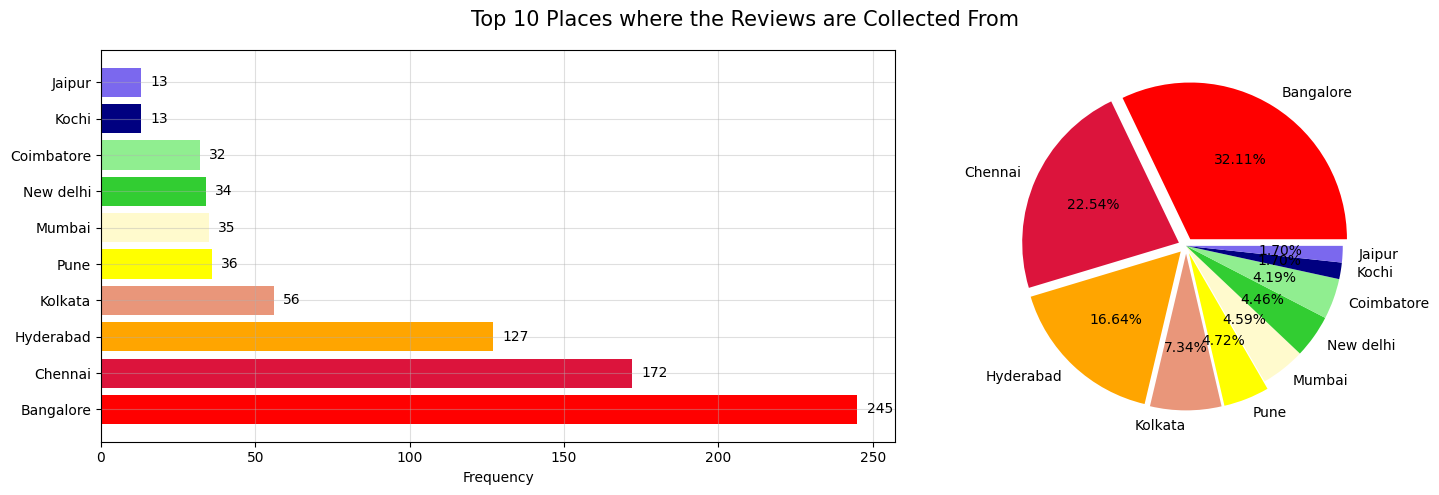

In [ ]:
address = data['address'].value_counts().sort_values(ascending=False)[:10]

colors = ['red','crimson','orange','darksalmon','yellow','lemonchiffon','limegreen','lightgreen','navy','mediumslateblue']
explodes = ([0.05]*5) + ([0]*5)

# visualization (top 10 places where the reviews are collected from)
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=address.index, width=address.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (address):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(address.values, labels=address.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Top 10 Places where the Reviews are Collected From', fontsize=15)
plt.tight_layout()
plt.show()

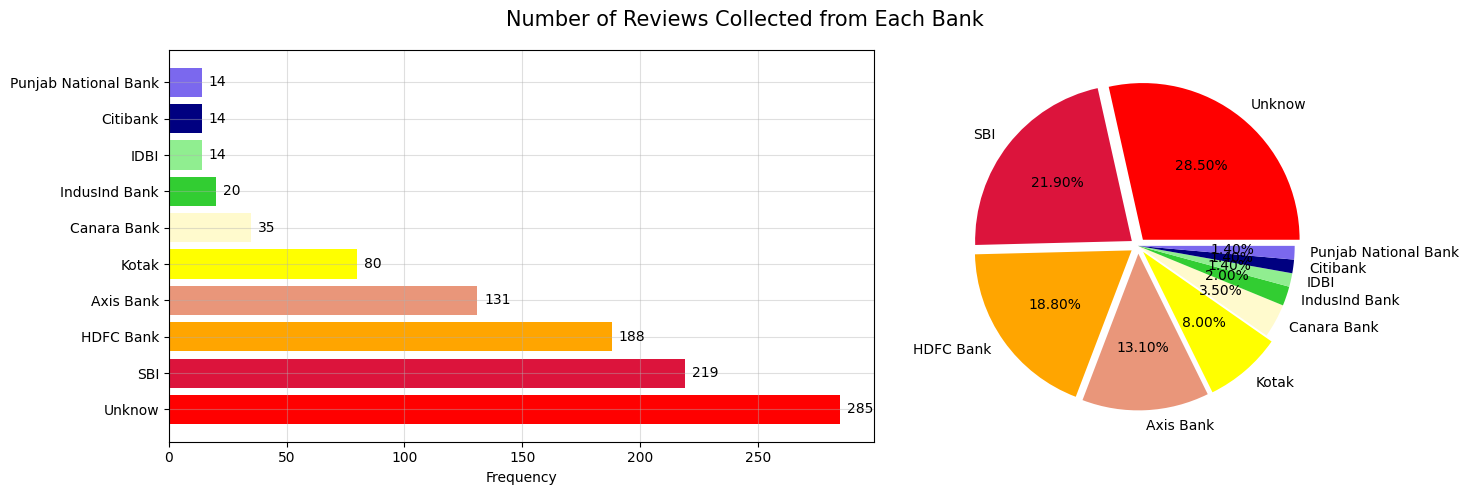

In [ ]:
# distribution of the data by 'bank'
bank = data['bank'].value_counts().sort_values(ascending=False)

# visualization in bar chart and pie chart
figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=bank.index, width=bank.values, color=colors)
axes[0].set_xlabel('Frequency')

for index, values in enumerate (bank):
    axes[0].text(values+3, index, str(values), va='center')

axes[0].grid(alpha=0.4)
axes[1].pie(bank.values, labels=bank.index, autopct='%.2f%%', explode=explodes, colors=colors)
figure.suptitle('Number of Reviews Collected from Each Bank', fontsize=15)
plt.tight_layout()
plt.show()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


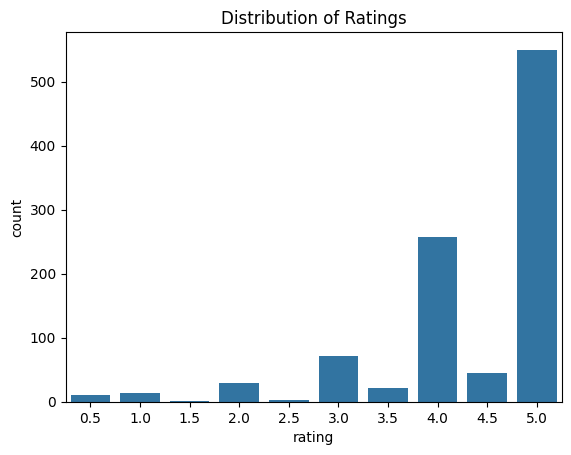

In [ ]:
sns.countplot(x='rating', data=data)
plt.title('Distribution of Ratings')
data['rating'].value_counts()

Text(0, 0.5, 'Frequency')

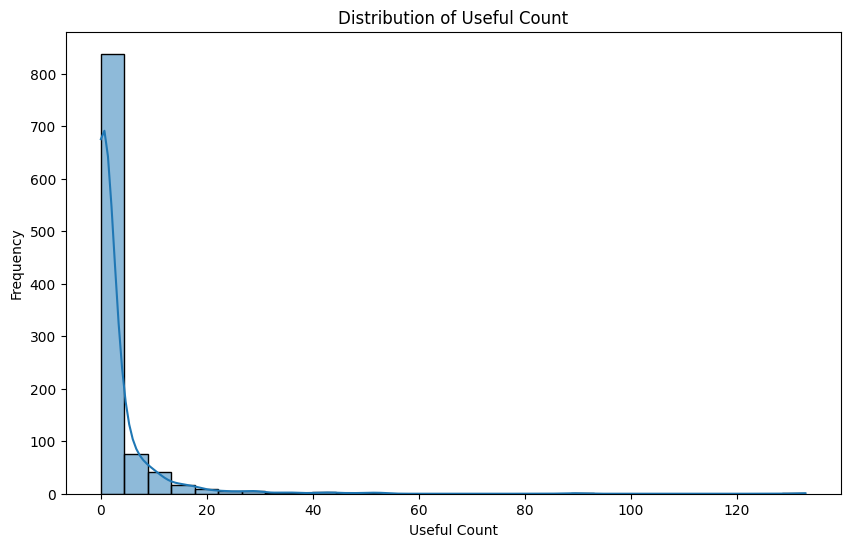

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data['useful_count'], bins=30, kde=True)
plt.title('Distribution of Useful Count')
plt.xlabel('Useful Count')
plt.ylabel('Frequency')

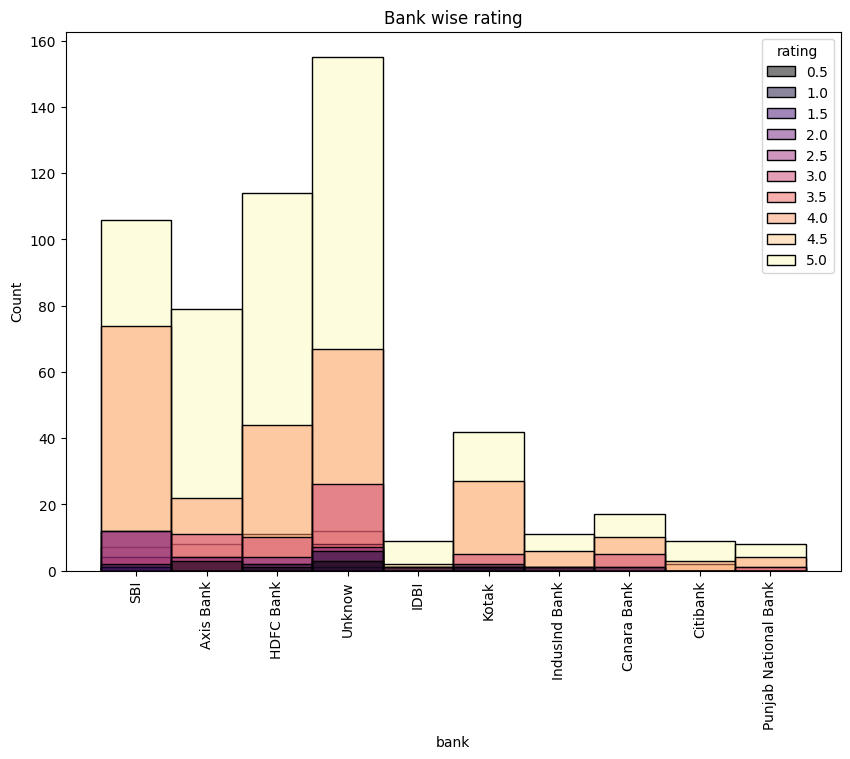

In [ ]:
fig, ax = plt.subplots(figsize=(10,7))
sns.histplot(data=data, x='bank', hue='rating', palette='magma')
plt.xticks(rotation=90)
plt.title('Bank wise rating')
plt.show()

In [ ]:
from plotly.express import line
line(data_frame=data.groupby(by='date').size().reset_index(), x='date', y=0)

In [ ]:
data['review'] = data['review'].str.replace('[^a-zA-Z0-9\s]', '')

Text(0.5, 1.0, 'Word Cloud for Reviews')

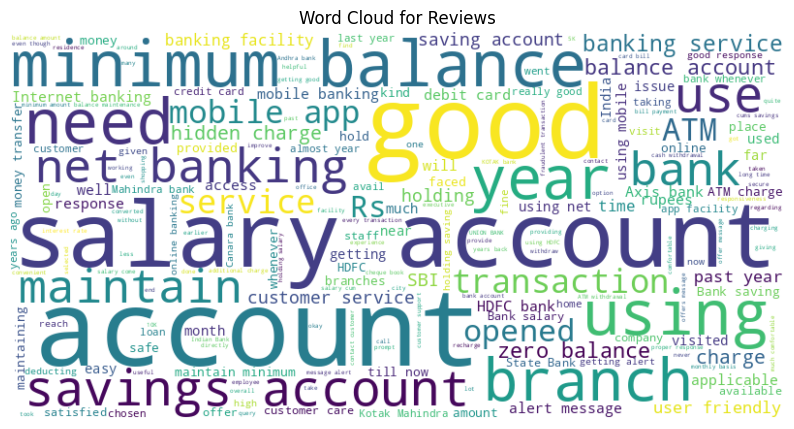

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, random_state=21, max_font_size=110, background_color='white').generate(' '.join(data['review']))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud for Reviews')

In [ ]:
# initialize the object of SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [ ]:
# calculate the polarity scores of the review
data['polarity'] = data['review'].apply(sia.polarity_scores)
data['compound'] = data['polarity'].apply(lambda x: x.get('compound'))

In [ ]:
# define a function to perform the sentiment categorization
def categorize(score):
    if score < 0:
        return 'To be Improved'
    elif score > 0.8:
        return 'Blown Away'
    else:
        return 'Neutral'

In [ ]:
# insert a new column 'Sentiment_Category' by categorized the sentiment based on the compound score
data['Sentiment_Category'] = data['compound'].apply(categorize)

# view the first 5 rows of the data after new columns inserted
data.head()

,author,date,address,bank,rating,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category
0,AMRENDRA T,21-Mar-20,New delhi,SBI,4.0,"""Best saving""",State Bank Of India is located nearby in our a...,Great!,133,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'comp...",0.7264,Neutral
1,BISHWA,20-Mar-20,Kolkata,SBI,5.0,"""Good service""","I have my salary account in SBI, when I applie...",Blown Away!,89,"{'neg': 0.0, 'neu': 0.875, 'pos': 0.125, 'comp...",0.7165,Neutral
2,SANTOSH,20-Mar-20,Hooghly,Axis Bank,5.0,"""Excellent Service""",I am using Axis bank saving account for the p...,Blown Away!,48,"{'neg': 0.08, 'neu': 0.785, 'pos': 0.135, 'com...",0.4588,Neutral
3,MAHADEV,20-Mar-20,Pune,HDFC Bank,5.0,"""Excellent service""",I have my salary bank account in HDFC bank for...,Blown Away!,52,"{'neg': 0.042, 'neu': 0.849, 'pos': 0.108, 'co...",0.5267,Neutral
4,R,20-Mar-20,Bangalore,Unknow,5.0,"""Good account""","Close to around 10 years, I am holding this Co...",Blown Away!,22,"{'neg': 0.0, 'neu': 0.837, 'pos': 0.163, 'comp...",0.7357,Neutral


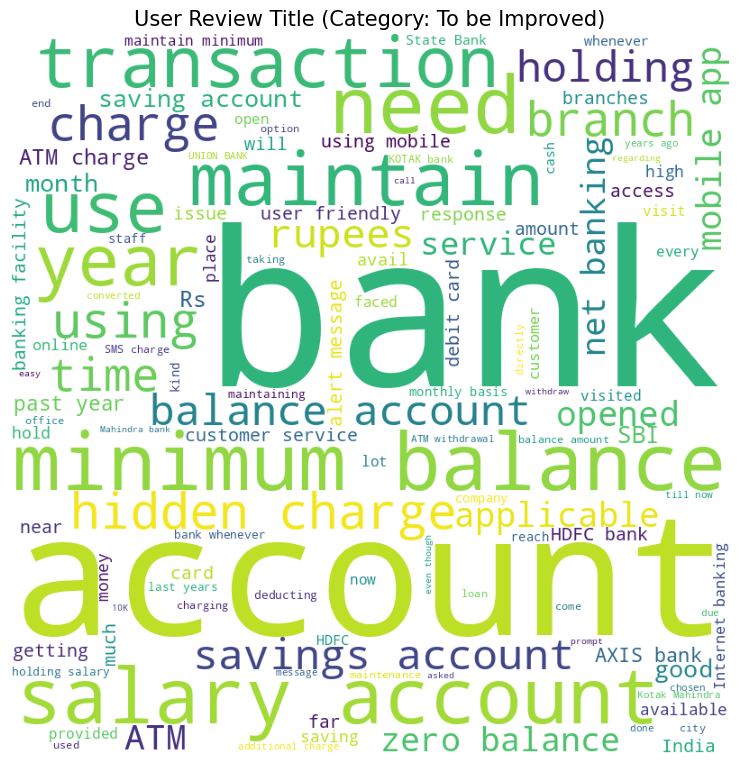

In [ ]:
data_copy = data.copy()
data_copy = data[data['Sentiment_Category']=='To be Improved']

combined_tobeImproved = ' '.join(data_copy['review'])


# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(combined_tobeImproved)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

In [ ]:
common_words = ['bank', 'account','salary','saving','savings','rupees']

pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, common_words)) + r')\b', flags=re.IGNORECASE)
filtered_string = pattern.sub('', combined_tobeImproved)

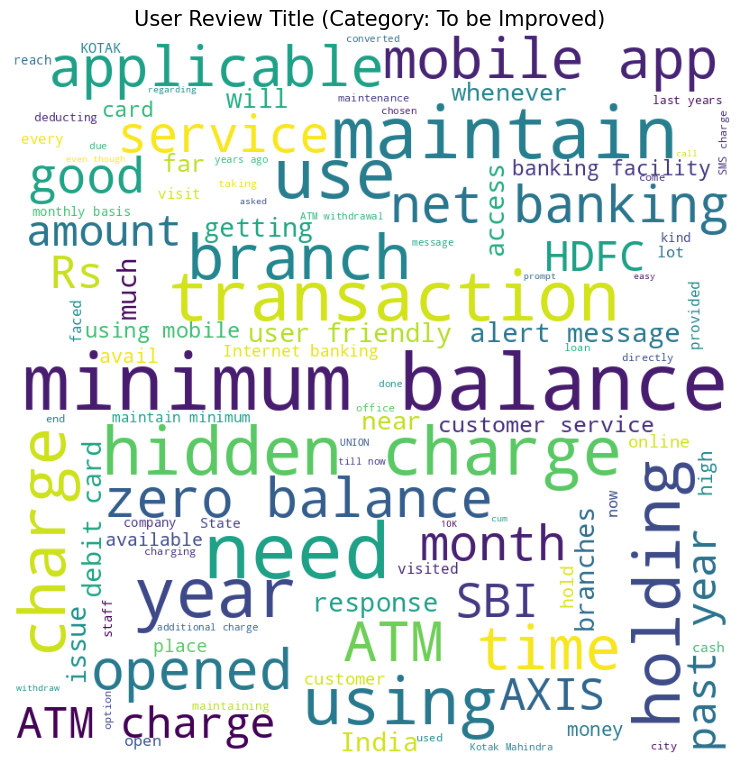

In [ ]:
# create a word cloud using the combined text
wordcloud_tobeImproved = WordCloud(width = 800, height = 800,
                            background_color ='white',
                            min_font_size = 10).generate(filtered_string)

# plot the WordCloud image
plt.figure(figsize=(8,8))
plt.imshow(wordcloud_tobeImproved)
plt.axis('off')
plt.title('User Review Title (Category: To be Improved)', fontsize=15)
plt.tight_layout(pad=2)
plt.show()

V/ Build model

In [ ]:
X = data.drop(columns=['rating'])
y = data[['rating']]

In [ ]:
y.value_counts()

,count
rating,
5.0,550
4.0,257
3.0,71
4.5,45
2.0,30
3.5,21
1.0,13
0.5,10
2.5,2


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [ ]:
temp = pd.concat([X_train, y_train], axis=1)
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
90,M H V,12-Mar-20,Chennai,Axis Bank,"""Good customer care service""",Axis bank have a good customer care because th...,Satisfactory,1,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.9403,Blown Away,3.0
451,A,27-Jan-20,Mumbai,Unknow,"""Average""","I have YES bank savings account, since i am u...",Great!,1,"{'neg': 0.053, 'neu': 0.772, 'pos': 0.175, 'co...",0.7695,Neutral,4.0
334,UMAPATHY,14-Feb-20,Chennai,HDFC Bank,"""Good """,I have salary account with HDFC bank for more ...,Blown Away!,0,"{'neg': 0.077, 'neu': 0.866, 'pos': 0.057, 'co...",0.1280,Neutral,5.0
246,RAM,23-Feb-20,Chennai,Unknow,"""Need to decrease charge """,I am having my salary account in INDIAN OVERSE...,Blown Away!,2,"{'neg': 0.035, 'neu': 0.929, 'pos': 0.036, 'co...",0.0258,Neutral,5.0
764,D,23-Dec-19,Coimbatore,SBI,"""Best service""",I have SBI saving account for more than 7 year...,Blown Away!,0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.8828,Blown Away,5.0


In [ ]:
testData = pd.concat([X_test, y_test], axis=1)
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
96,S B,11-Mar-20,Pune,Unknow,"""Good account for high salaried people""",I opened my salary account with Standard Chart...,Blown Away!,7,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.7140,Neutral,5.0
787,ANONYMOUS,20-Dec-19,Bangalore,Unknow,"""Okay Account""",Vijaya bank account service is okay because i ...,Pretty good,0,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.7778,Neutral,3.5
429,ANONYMOUS,28-Jan-20,Bangalore,HDFC Bank,"""Improve on communication skills""",HDFC customer care service is not good becaus...,Expected more,1,"{'neg': 0.038, 'neu': 0.91, 'pos': 0.051, 'com...",0.2008,Neutral,2.0
327,ROKADE,15-Feb-20,Pune,Axis Bank,"""Need to improve the services""",Earlier i was having a salary account from Axi...,Satisfactory,2,"{'neg': 0.077, 'neu': 0.892, 'pos': 0.031, 'co...",-0.1779,To be Improved,3.0
772,LA,22-Dec-19,Coimbatore,SBI,"""Need to decrease charges""",I am holding a saving account with SBI for pas...,Great!,0,"{'neg': 0.097, 'neu': 0.835, 'pos': 0.068, 'co...",-0.1531,To be Improved,4.0


In [ ]:
temp.shape

(750, 12)

In [ ]:
testData.shape

(250, 12)

In [ ]:
le = LabelEncoder()
for col in categoricalCol:
    temp[col] = le.fit_transform(temp[col])
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
90,224,13,14,0,111,33,7,1,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.9403,Blown Away,3.0
451,0,68,61,9,9,371,3,1,"{'neg': 0.053, 'neu': 0.772, 'pos': 0.175, 'co...",0.7695,Neutral,4.0
334,442,19,14,3,78,502,0,0,"{'neg': 0.077, 'neu': 0.866, 'pos': 0.057, 'co...",0.1280,Neutral,5.0
246,348,56,14,9,151,123,0,2,"{'neg': 0.035, 'neu': 0.929, 'pos': 0.036, 'co...",0.0258,Neutral,5.0
764,94,55,18,8,39,356,0,0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.8828,Blown Away,5.0


In [ ]:
le = LabelEncoder()
for col in categoricalCol:
    testData[col] = le.fit_transform(testData[col])
testData.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating
96,140,8,42,9,50,176,1,7,"{'neg': 0.0, 'neu': 0.923, 'pos': 0.077, 'comp...",0.7140,Neutral,5.0
787,15,37,4,9,102,244,6,0,"{'neg': 0.0, 'neu': 0.862, 'pos': 0.138, 'comp...",0.7778,Neutral,3.5
429,15,61,4,3,67,33,3,1,"{'neg': 0.038, 'neu': 0.91, 'pos': 0.051, 'com...",0.2008,Neutral,2.0
327,132,18,42,0,84,19,8,2,"{'neg': 0.077, 'neu': 0.892, 'pos': 0.031, 'co...",-0.1779,To be Improved,3.0
772,80,44,10,8,71,60,4,0,"{'neg': 0.097, 'neu': 0.835, 'pos': 0.068, 'co...",-0.1531,To be Improved,4.0


In [ ]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
temp['polarity_value'] = temp['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu

In [ ]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
temp['Sentiment_Category'] = label_encoder.fit_transform(temp['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
temp['Polarity_Category'] = pd.cut(temp['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [ ]:
# Trích xuất giá trị 'pos' từ cột 'polarity'
testData['polarity_value'] = testData['polarity'].apply(lambda x: x['pos'])  # Hoặc x['neg'] hay x['neu'] tùy theo yêu cầu

In [ ]:
# Mã hóa cột Sentiment_Category
label_encoder = LabelEncoder()
testData['Sentiment_Category'] = label_encoder.fit_transform(testData['Sentiment_Category'])

# Mã hóa cột polarity thành các loại
testData['Polarity_Category'] = pd.cut(testData['polarity_value'], bins=[-1, 0.1, 0.9, 1],
                                    labels=['Negative', 'Neutral', 'Positive'])


In [ ]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,polarity,compound,Sentiment_Category,rating,polarity_value,Polarity_Category
90,224,13,14,0,111,33,7,1,"{'neg': 0.0, 'neu': 0.741, 'pos': 0.259, 'comp...",0.9403,0,3.0,0.259,Neutral
451,0,68,61,9,9,371,3,1,"{'neg': 0.053, 'neu': 0.772, 'pos': 0.175, 'co...",0.7695,1,4.0,0.175,Neutral
334,442,19,14,3,78,502,0,0,"{'neg': 0.077, 'neu': 0.866, 'pos': 0.057, 'co...",0.1280,1,5.0,0.057,Negative
246,348,56,14,9,151,123,0,2,"{'neg': 0.035, 'neu': 0.929, 'pos': 0.036, 'co...",0.0258,1,5.0,0.036,Negative
764,94,55,18,8,39,356,0,0,"{'neg': 0.0, 'neu': 0.806, 'pos': 0.194, 'comp...",0.8828,0,5.0,0.194,Neutral


In [ ]:
temp = temp.drop(columns=['polarity', 'Polarity_Category'])
testData= testData.drop(columns=['polarity', 'Polarity_Category'])

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Assuming 'author', 'date', and 'address' are the problematic columns
# Convert 'author', 'date', and 'address' to numerical representation using Label Encoding
# Here we will use Label Encoding as an example:
# Get a list of all object (string) columns in your DataFrame
object_cols = X_train.select_dtypes(include=['object']).columns

# Loop through all object (string) columns and apply Label Encoding
for column in object_cols:
    # Check if the column contains dictionaries
    if X_train[column].apply(type).eq(dict).any():
        # If the column contains dictionaries, extract the desired values (e.g., 'pos')
        X_train[column + '_value'] = X_train[column].apply(lambda x: x.get('pos', None) if isinstance(x, dict) else x)  # Handle potential errors if not a dict
        # Drop the original column with dictionaries
        X_train = X_train.drop(columns=[column])
        # Now apply Label Encoding to the extracted value column
        encoder = LabelEncoder()
        X_train[column + '_value'] = encoder.fit_transform(X_train[column + '_value'].astype(str))  # Convert to string before encoding
    else:
        # Apply Label Encoding to other object columns as usual
        encoder = LabelEncoder()  # Create a new encoder for each column
        X_train[column] = encoder.fit_transform(X_train[column])

# Now you can apply StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [ ]:
X_train

array([[ 0.06553113, -1.3000169 , -0.72496929, ...,  1.21871118,
        -1.57225253,  2.09309679],
       [-1.45823777,  0.50744871,  1.12860055, ...,  0.86295729,
        -0.04678112,  1.12611848],
       [ 1.54848479, -1.10283883, -0.72496929, ..., -0.47320266,
        -0.04678112, -0.77449405],
       ...,
       [-0.29500347,  1.36188699,  1.12860055, ..., -2.44880315,
         1.47869029, -1.4247036 ],
       [-1.2405565 , -1.13570184,  0.1820968 , ..., -1.7685384 ,
         1.47869029, -1.3413434 ],
       [ 1.71854829, -1.3000169 , -0.96159522, ..., -0.73980979,
        -0.04678112, -1.4247036 ]])

PCA

In [ ]:
pca = PCA(n_components = 8)
pca.fit_transform(X_train);

In [ ]:
pca.explained_variance_ratio_

array([0.25386261, 0.10686687, 0.09944408, 0.09513469, 0.09291277,
       0.09109576, 0.08317056, 0.07659146])

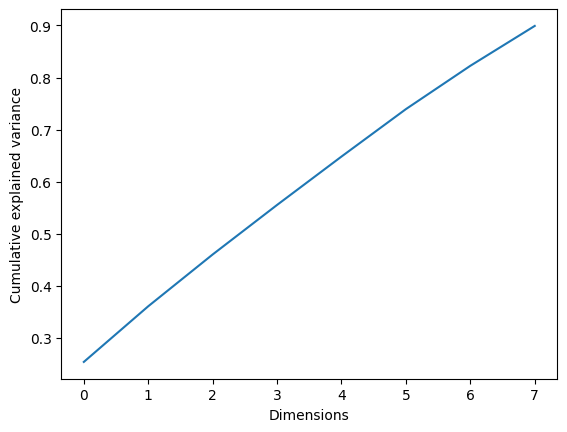

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Dimensions')
plt.ylabel('Cumulative explained variance');

In [ ]:
temp['kFold'] = -1

In [ ]:
temp.head()

,author,date,address,bank,review_title_by_user,review,rating_title_by_user,useful_count,compound,Sentiment_Category,rating,polarity_value,kFold
90,224,13,14,0,111,33,7,1,0.9403,0,3.0,0.259,-1
451,0,68,61,9,9,371,3,1,0.7695,1,4.0,0.175,-1
334,442,19,14,3,78,502,0,0,0.1280,1,5.0,0.057,-1
246,348,56,14,9,151,123,0,2,0.0258,1,5.0,0.036,-1
764,94,55,18,8,39,356,0,0,0.8828,0,5.0,0.194,-1


In [ ]:
X_test = testData.drop('rating', axis=1)
y_test = testData['rating']

In [ ]:
y_train

,rating
90,3.0
451,4.0
334,5.0
246,5.0
764,5.0
...,...
926,5.0
200,5.0
145,4.0
836,4.5


In [ ]:
y_train = np.where(y_train <= 3.0, 'bad',
                   np.where(y_train >= 4.0, 'good', 'neutral'))

y_test = np.where(y_test <= 3.0, 'bad',
                  np.where(y_test >= 4.0, 'good', 'neutral'))

In [ ]:
X_test = scaler.transform(X_test)

In [ ]:
y_test

array(['good', 'neutral', 'bad', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'bad', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'bad', 'good',
       'good', 'bad', 'good', 'good', 'good', 'good', 'good', 'good',
       'bad', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'bad', 'good', 'neutral', 'good', 'good', 'good',
       'neutral', 'bad', 'good', 'good', 'bad', 'good', 'bad', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'bad', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'bad',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good', 'good', 'good', 'good', 'good', 'good', 'good', 'good',
       'good',

Logistic **Regression**

In [ ]:
# Huấn luyện mô hình
model = LogisticRegression()
model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
pred_lr = model.predict(X_test)

In [ ]:
report = classification_report(y_test, pred_lr)
print(report)

              precision    recall  f1-score   support

         bad       0.81      0.73      0.77        41
        good       0.95      1.00      0.97       203
     neutral       0.00      0.00      0.00         6

    accuracy                           0.93       250
   macro avg       0.59      0.58      0.58       250
weighted avg       0.90      0.93      0.91       250



Tối ưu hoá tham số

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 300]
}

# Khởi tạo mô hình Logistic Regression
log_reg = LogisticRegression()

# Sử dụng GridSearchCV để tìm các siêu tham số tốt nhất
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='accuracy', verbose=1)

# Huấn luyện với bộ dữ liệu
grid_search.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

# Đánh giá mô hình với dữ liệu kiểm thử
best_model = grid_search.best_estimator_
test_accuracy = best_model.score(X_test, y_test)
print(f"Test set accuracy: {test_accuracy}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters found: {'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.9506666666666668
Test set accuracy: 0.928


In [ ]:
y_pred = best_model.predict(X_test)

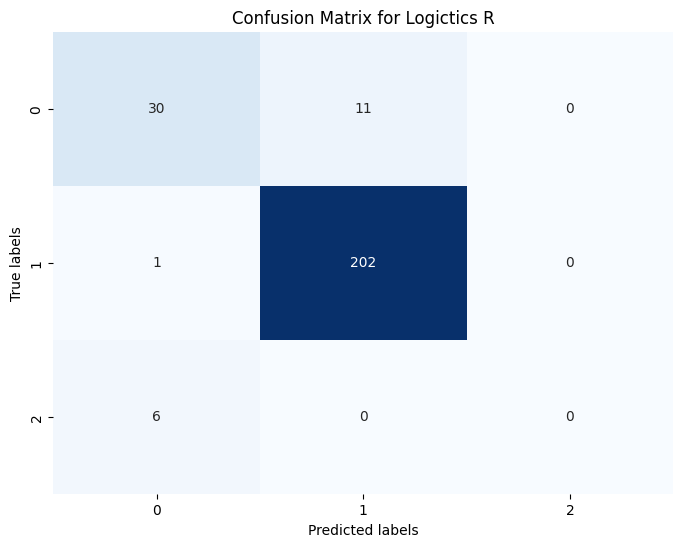

In [ ]:
cm = confusion_matrix(y_test, pred_lr)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logictics R')
plt.show()

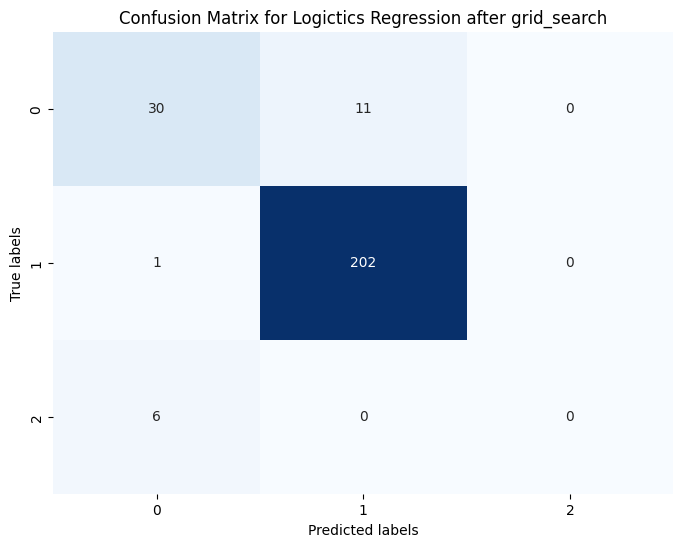

In [ ]:
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for Logictics Regression after grid_search')
plt.show()

 Random Forest

In [ ]:
rf_model = RandomForestClassifier(random_state=12)
rf_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
rf_pred = rf_model.predict(X_test)

# In ra bảng report
rf_report = classification_report(y_test, rf_pred, target_names=['bad', 'good', 'neutral'])
print(rf_report)

              precision    recall  f1-score   support

         bad       0.84      0.76      0.79        41
        good       0.95      1.00      0.98       203
     neutral       0.00      0.00      0.00         6

    accuracy                           0.94       250
   macro avg       0.60      0.59      0.59       250
weighted avg       0.91      0.94      0.92       250



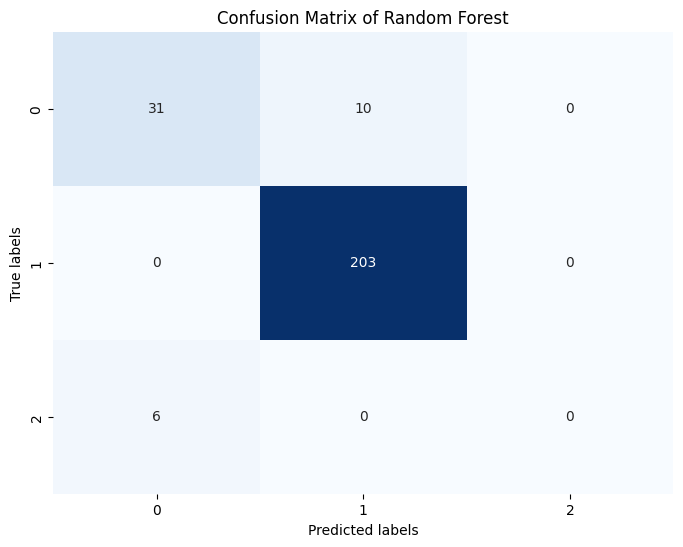

In [ ]:
cm = confusion_matrix(y_test, rf_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest')
plt.show()

Tuning forest

In [ ]:
# Định nghĩa lưới siêu tham số cần tuning
param_grid = {
    'n_estimators': [100, 200, 300],  # Số lượng cây trong rừng
    'max_depth': [10, 20, 30, None],  # Chiều sâu tối đa
    'min_samples_split': [2, 5, 10],  # Số lượng mẫu tối thiểu để tách
    'min_samples_leaf': [1, 2, 4],    # Số lượng mẫu tối thiểu ở mỗi node lá
    'max_features': ['auto', 'sqrt'], # Số lượng đặc trưng khi tách
    'bootstrap': [True, False]        # Lấy mẫu với hoặc không với bootstrapping
}

# Sử dụng GridSearchCV để tìm các siêu tham số tốt nhất
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)

# Huấn luyện mô hình với tập huấn luyện
grid_search_rf.fit(X_train, y_train)

# In ra các siêu tham số tốt nhất
print(f"Best parameters found: {grid_search_rf.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_rf.best_score_}")

# Đánh giá mô hình tốt nhất trên tập kiểm thử
best_rf_model = grid_search_rf.best_estimator_
rf_pred_tuned = best_rf_model.predict(X_test)

# In ra bảng report sau khi tuning
rf_report_tuned = classification_report(y_test, rf_pred_tuned, target_names=['bad', 'good', 'neutral'])
print(rf_report_tuned)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters found: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best cross-validation accuracy: 0.9786666666666667
              precision    recall  f1-score   support

         bad       0.35      0.76      0.48        41
        good       0.94      0.71      0.81       203
     neutral       0.00      0.00      0.00         6

    accuracy                           0.70       250
   macro avg       0.43      0.49      0.43       250
weighted avg       0.82      0.70      0.73       250



In [ ]:
y_pred_rf = best_rf_model.predict(X_test)

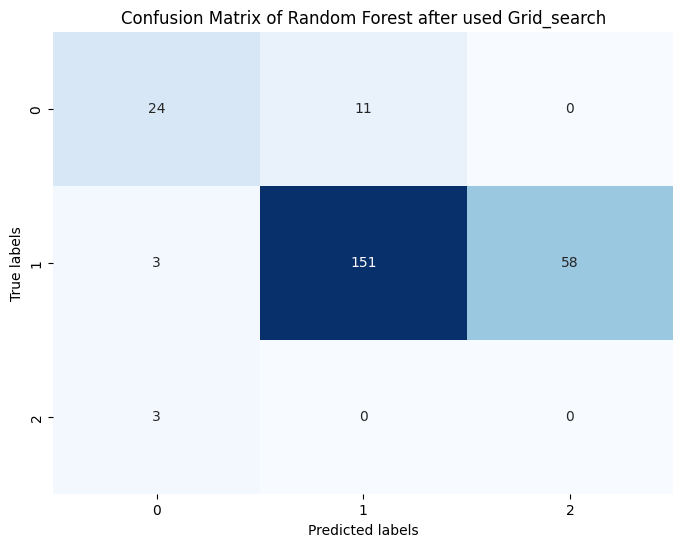

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix of Random Forest after used Grid_search')
plt.show()

Catboost

In [ ]:
# Huấn luyện mô hình CatBoost
catboost_model = CatBoostClassifier(iterations=1000,
                                     learning_rate=0.1,
                                     depth=6,
                                     verbose=0)  # Set verbose=0 to suppress output
catboost_model.fit(X_train, y_train)

# Dự đoán trên tập kiểm tra
catboost_pred = catboost_model.predict(X_test)

# In ra bảng report
catboost_report = classification_report(y_test, catboost_pred, target_names=['bad', 'good', 'neutral'])
print(catboost_report)

              precision    recall  f1-score   support

         bad       0.67      0.69      0.68        35
        good       0.93      0.67      0.78       212
     neutral       0.00      0.00      0.00         3

    accuracy                           0.66       250
   macro avg       0.53      0.45      0.48       250
weighted avg       0.88      0.66      0.75       250



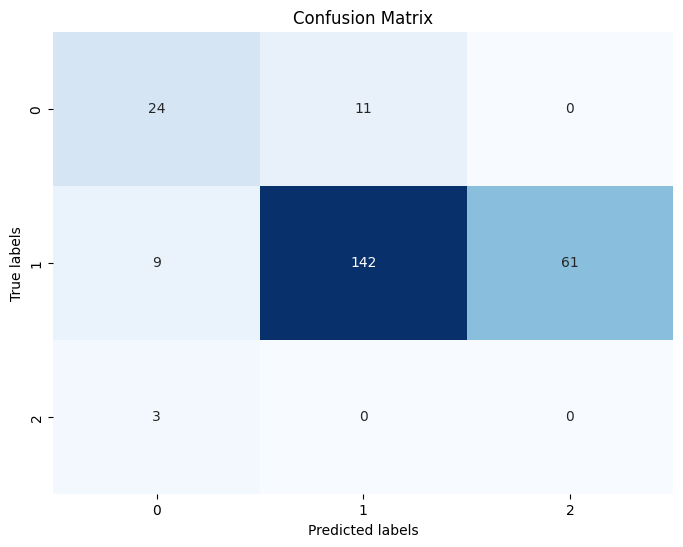

In [ ]:
cm = confusion_matrix(y_test, catboost_pred)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Tuning catboost

In [ ]:
def objective(trial):
    # Hyperparameter tuning
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_state': 42,
        'verbose': 0
    }

    # Train the CatBoost model
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions and calculate F1 score
    preds = model.predict(X_test)  # Assume you have a validation set
    f1 = f1_score(y_test, preds, average='weighted')

    return f1

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)  # Adjust the number of trials as needed

[I 2024-11-04 03:16:46,816] A new study created in memory with name: no-name-18079791-3e4b-43ab-beda-56d0a9c83e22
[I 2024-11-04 03:16:48,656] Trial 0 finished with value: 0.7544615859540806 and parameters: {'iterations': 477, 'learning_rate': 0.17227118504801278, 'depth': 6, 'l2_leaf_reg': 8.4261360888407}. Best is trial 0 with value: 0.7544615859540806.
[I 2024-11-04 03:17:06,934] Trial 1 finished with value: 0.7544615859540806 and parameters: {'iterations': 684, 'learning_rate': 0.06636272013300376, 'depth': 9, 'l2_leaf_reg': 7.181292595541529}. Best is trial 0 with value: 0.7544615859540806.
[I 2024-11-04 03:17:32,752] Trial 2 finished with value: 0.7544615859540806 and parameters: {'iterations': 915, 'learning_rate': 0.04392549354649971, 'depth': 9, 'l2_leaf_reg': 9.148182692929948}. Best is trial 0 with value: 0.7544615859540806.
[I 2024-11-04 03:17:46,866] Trial 3 finished with value: 0.7544615859540806 and parameters: {'iterations': 974, 'learning_rate': 0.20534255503343923, 'de

In [ ]:
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'iterations': 477, 'learning_rate': 0.17227118504801278, 'depth': 6, 'l2_leaf_reg': 8.4261360888407}


In [ ]:
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

# Optionally, evaluate the model on the test set
final_preds = final_model.predict(X_test)
final_report = classification_report(y_test, final_preds, target_names=['bad', 'good', 'neutral'])
print(final_report)


0:	learn: 0.9103829	total: 11.7ms	remaining: 5.57s
1:	learn: 0.7509161	total: 18.3ms	remaining: 4.34s
2:	learn: 0.6237630	total: 23.6ms	remaining: 3.73s
3:	learn: 0.5484444	total: 28ms	remaining: 3.32s
4:	learn: 0.4820868	total: 33ms	remaining: 3.11s
5:	learn: 0.4222495	total: 37.2ms	remaining: 2.92s
6:	learn: 0.3793229	total: 42.2ms	remaining: 2.83s
7:	learn: 0.3417380	total: 47.8ms	remaining: 2.8s
8:	learn: 0.3113737	total: 52.6ms	remaining: 2.74s
9:	learn: 0.2717772	total: 56.1ms	remaining: 2.62s
10:	learn: 0.2540854	total: 62.9ms	remaining: 2.66s
11:	learn: 0.2315215	total: 68.8ms	remaining: 2.67s
12:	learn: 0.2156742	total: 74.2ms	remaining: 2.65s
13:	learn: 0.2003667	total: 78.7ms	remaining: 2.6s
14:	learn: 0.1813560	total: 84.1ms	remaining: 2.59s
15:	learn: 0.1629840	total: 89.1ms	remaining: 2.57s
16:	learn: 0.1493188	total: 94.6ms	remaining: 2.56s
17:	learn: 0.1344195	total: 99.1ms	remaining: 2.53s
18:	learn: 0.1286946	total: 104ms	remaining: 2.51s
19:	learn: 0.1229054	total: 1

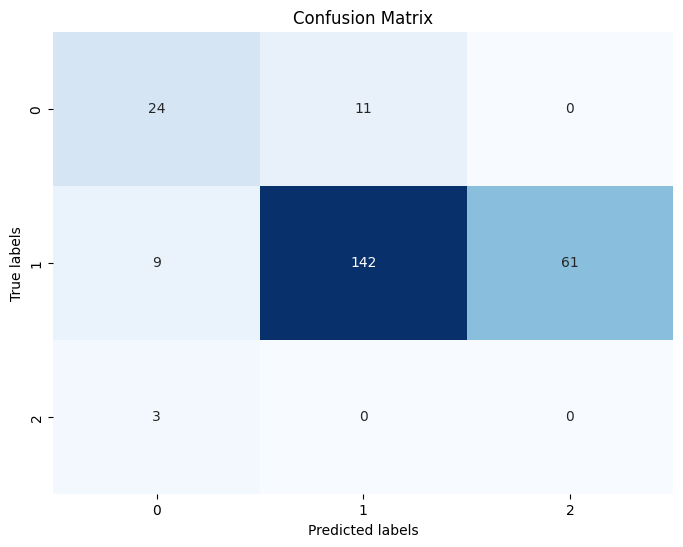

In [ ]:
cm = confusion_matrix(y_test,final_preds)

# Vẽ ma trận confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

Thư viện gradio

In [ ]:
!pip install -q comet_ml gradio

import gradio as g

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 4.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 697.1/697.1 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 26.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 969.5/969.5 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.7/94.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.5/447.5 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 102.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 5.9 MB/s e

Huấn luyện mô hình Logistic Regression

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# Assuming X_train is a NumPy array and 'review' data is in a specific column:
# Replace 'column_index' with the actual index of the 'review' column in X_train
column_index = 0  # Example: Assuming 'review' is in the first column (index 0)
X_train_text = X_train[:, column_index]

# Convert to a pandas DataFrame for easier handling if needed
X_train_df = pd.DataFrame(X_train)
# Get the actual number of columns in X_train
num_cols = X_train.shape[1]

# Create a list of column names with the correct length
X_train_df.columns = [f'Column{i}' for i in range(1, num_cols + 1)]
# Now you can access 'review' column, assuming it was in the column index you specified
X_train_text = X_train_df[X_train_df.columns[column_index]].astype(str)

# Initialize the CountVectorizer before using it
vectorizer = CountVectorizer()  # Create an instance of CountVectorizer

# Now you can apply fit_transform:
X_train_vectorized = vectorizer.fit_transform(X_train_text)

# Huấn luyện mô hình Logistic Regression
model = LogisticRegression()
model.fit(X_train_vectorized, y_train)

LogisticRegression()

Khởi tạo hàm dự đoán và giao diện mô hình

In [ ]:
# Hàm dự đoán
def predict_label(input_text):
    input_vectorized = vectorizer.transform([input_text])
    prediction = model.predict(input_vectorized)
    return str(prediction[0])

# Tạo giao diện Gradio
import gradio as gr # Import gradio within the code block
iface = gr.Interface(fn=predict_label,
                     inputs="text",
                     outputs="text",
                     title="Dự đoán nhãn với Logistic Regression",
                     description="Nhập một đoạn văn bản và mô hình sẽ dự đoán nhãn của nó (0, 1, hoặc 2).")

# Khởi chạy giao diện
iface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://4ba9e2c73e8d65d45d.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import gradio as gr

def classify_text(text):
    """
    Phân loại văn bản thành 'good', 'bad', hoặc 'neu'.
    """
    # Ví dụ quy tắc đơn giản cho việc phân loại
    if "good" in text.lower():
        return "good"
    elif "bad" in text.lower():
        return "bad"
    else:
        return "neu"

# Tạo giao diện Gradio
interface = gr.Interface(
    fn=classify_text,  # Hàm phân loại
    inputs="text",     # Đầu vào là văn bản
    outputs="text",    # Đầu ra là văn bản (good, bad, neu)
    title="Dự đoán nhãn với Logistic Regression",
    description="Nhập văn bản và nhận kết quả phân loại là good, bad, hoặc neu."
)

# Chạy giao diện
interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://17a443ddd7df073028.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
